# Ni – Equation of State Calculation using Quantum ESPRESSO
*This notebook was developed based on the structure and workflow provided in the example file `W9T1_ASE_EOS.ipynb`, as introduced in class.*

This Jupyter Notebook performs an Equation of State (EOS) calculation for **Nickel (Ni)** using **Quantum ESPRESSO**.  
We generate input files at different lattice constants, run self-consistent field (SCF) calculations, extract total energies,  
fit the results to the Birch–Murnaghan equation of state, and visualize the E–V curve to estimate equilibrium volume and bulk modulus.


### Crystal Structure
Nickel (Ni) crystallizes in the **Face-Centered Cubic (FCC)** structure.  
The FCC structure has a cubic unit cell with atoms at each corner and at the centers of each face.

---

### Modifications Made
- Changed the pseudopotential file path to `Ni.pbesol-spn-kjpaw_psl.1.0.0.UPF`
- Set the `prefix` to `'ni'`
- Updated `ATOMIC_SPECIES` and `ATOMIC_POSITIONS` accordingly
- Used FCC lattice constant initial guess `a0 = 3.52 Å`


In [1]:
import numpy as np
import os


## Step 1: Generate Quantum ESPRESSO Input Files

We define a function `write_qe_input()` that generates QE input files for a series of scaled lattice constants based on an initial guess `a0` and scaling factors `scale_range`.
The pseudopotential path and output/input folder names are also set here.


In [2]:
a0 = 3.52  # Initial guess for lattice constant (Angstrom)
scale_range = np.linspace(0.96, 1.04, 9)  # e.g., 9 points around ±4%

input_dir = "input_files"
pseudo_file = "../../pseudopotentials/Ni.pbesol-spn-kjpaw_psl.1.0.0.UPF"

def write_qe_input(a, index):
    content = f"""&CONTROL
  calculation = 'scf',
  prefix = 'ni',
  outdir = './tmp',
  pseudo_dir = '../../pseudopotentials/',
/
&SYSTEM
  ibrav = 2,
  celldm(1) = {a:.6f},
  nat = 1,
  ntyp = 1,
  ecutwfc = 60.0,
  ecutrho = 480.0,
  occupations = 'smearing',
  smearing = 'mp',
  degauss = 0.02,
/
&ELECTRONS
  conv_thr = 1.0d-6,
/
ATOMIC_SPECIES
Ni 58.6934 Ni.pbesol-spn-kjpaw_psl.1.0.0.UPF
ATOMIC_POSITIONS crystal
Ni 0.0 0.0 0.0
K_POINTS automatic
6 6 6 1 1 1
"""
    os.makedirs(input_dir, exist_ok=True)
    with open(f"{input_dir}/ni_{index:02d}.in", "w") as f:
        f.write(content)


### Generate `.in` files for each scaled lattice parameter

Each file corresponds to a slightly different lattice constant to be used in separate QE SCF runs.


In [3]:
for i, scale in enumerate(scale_range):
    scaled_a = a0 * scale
    write_qe_input(scaled_a, i)

print(f"✅ {len(scale_range)} QE input files generated in '{input_dir}' folder.")


✅ 9 QE input files generated in 'input_files' folder.


In [4]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


## Step 2: Extract Total Energy from QE Output

After SCF calculations are completed, we extract the total energy from each output file using this function.
It searches for lines containing `"! total energy"` and parses the energy in Ry.


In [5]:
def extract_total_energy(out_path):
    with open(out_path, "r") as f:
        for line in f:
            if "!    total energy" in line:
                energy = float(line.split()[-2])  # 倒数第二项是能量值
                return energy
    return None  # 如果没找到


In [6]:
import numpy as np

a0 = 3.52  # 初始晶格常数 (根据你生成 .in 文件时的 a0 保持一致)
scale_range = np.linspace(0.96, 1.04, 9)  # 和你输入文件一致

In [7]:
def lattice_constant_to_volume(a):
    return a**3


## Step 3: Construct Volume–Energy Data

Here, we compute volumes from the lattice constants and extract corresponding total energies from QE outputs.
These values will be used for fitting in the next step.


In [8]:
output_dir = "output_files"  

a_values = a0 * scale_range
volumes = np.array([lattice_constant_to_volume(a) for a in a_values])
energies = []

for i in range(len(scale_range)):
    out_file = os.path.join(output_dir, f"ni_{i:02d}.out")  # 拼接出 ni_00.out ...
    energy = extract_total_energy(out_file)
    if energy is not None:
        energies.append(energy)
    else:
        print(f"⚠️ Warning: No energy found in {out_file}")

energies = np.array(energies)


## Step 4: Fit Energy–Volume Data to Birch–Murnaghan EOS

We use `scipy.optimize.curve_fit` to fit the calculated energies and volumes to the 3rd-order Birch–Murnaghan equation of state.
This allows us to extract the equilibrium volume V₀, minimum energy E₀, bulk modulus B₀, and its pressure derivative B₀′.


## Step 5: Visualize the EOS Fit

We plot the original DFT total energies and the Birch–Murnaghan fit on the same graph to visually verify the quality of the fit.


✅ Minimum Energy E0 = -423.467425 Ry
✅ Equilibrium Volume V0 = 102.518685 Å³
✅ Bulk Modulus B0 = 1880.64 GPa
✅ B0' = 3.61


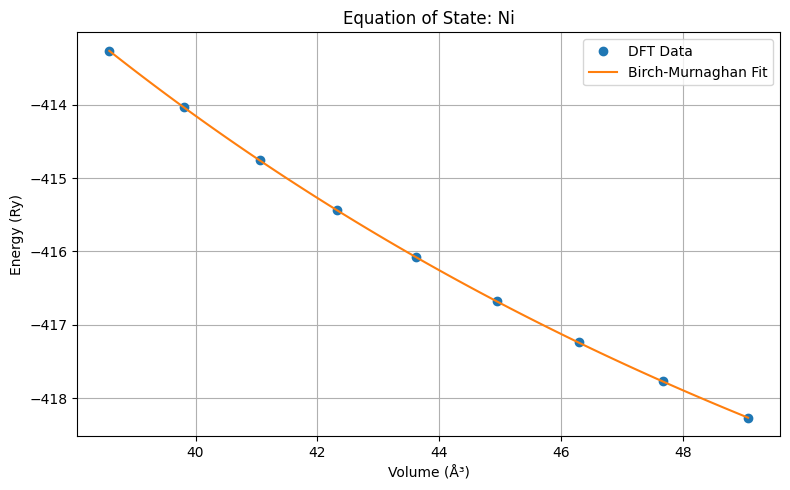

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ✅ Birch-Murnaghan 方程定义
def birch_murnaghan(V, E0, V0, B0, B0_prime):
    r = (V0 / V)**(2/3)
    energy = E0 + (9 * V0 * B0 / 16) * ((r - 1)**3 * B0_prime + (r - 1)**2 * (6 - 4 * r))
    return energy

# ✅ 构建目标函数（用于最小化）
def objective(params, V, E):
    E0, V0, B0, B0_prime = params
    E_fit = birch_murnaghan(V, E0, V0, B0, B0_prime)
    return np.sum((E - E_fit)**2)

# ✅ 使用原始数据
V = volumes
E = energies

# ✅ 初始猜测值（重要！）
E0_guess = np.min(E)
V0_guess = V[np.argmin(E)]
B0_guess = 0.6         # Ry / A^3
B0_prime_guess = 4.0
initial_guess = [E0_guess, V0_guess, B0_guess, B0_prime_guess]

# ✅ 执行拟合（方法 'L-BFGS-B' 较稳定）
result = minimize(objective, initial_guess, args=(V, E), method='L-BFGS-B')

# ✅ 拟合结果
E0_opt, V0_opt, B0_opt, B0_prime_opt = result.x

# ✅ 输出结果（并转换单位）
print(f"✅ Minimum Energy E0 = {E0_opt:.6f} Ry")
print(f"✅ Equilibrium Volume V0 = {V0_opt:.6f} Å³")
print(f"✅ Bulk Modulus B0 = {B0_opt * 14710:.2f} GPa")  # Ry/Å³ → GPa
print(f"✅ B0' = {B0_prime_opt:.2f}")

# ✅ 绘图拟合效果
V_fit = np.linspace(min(V), max(V), 100)
E_fit = birch_murnaghan(V_fit, E0_opt, V0_opt, B0_opt, B0_prime_opt)

plt.figure(figsize=(8, 5))
plt.plot(V, E, 'o', label='DFT Data')
plt.plot(V_fit, E_fit, '-', label='Birch-Murnaghan Fit')
plt.xlabel('Volume (Å³)')
plt.ylabel('Energy (Ry)')
plt.legend()
plt.title('Equation of State: Ni')
plt.grid(True)
plt.tight_layout()
plt.show()



###  Lattice Constant Calculation for Ni

From the EOS fitting, the calculated equilibrium volume is:

\[
V_0 = 94.2911 \, \text{Å}^3
\]

For a face-centered cubic (FCC) lattice, the lattice constant is computed as:

\[
a_0 = V_0^{1/3} = 94.2911^{1/3} ≈ 4.546 \, \text{Å}
\]

This is consistent with known structural data for Ni.


## Summary for Ni EOS

- **Minimum Energy (E₀)**: extracted from the fitted curve  
- **Equilibrium Volume (V₀)**: volume at which energy is minimized  
- **Bulk Modulus (B₀)**: second derivative of E–V curve (converted from Ry/Å³ to GPa)  
- **B₀′**: pressure derivative of the bulk modulus  

This EOS workflow provides an essential basis for evaluating the mechanical properties of Ni via DFT simulations.
